In [2]:
import os
import pandas as pd
import json
import cv2
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

In [3]:
DATA_IMG_PATH = "/opt/ml/detection/dataset/train"
DATA_JSON_PATH = "/opt/ml/detection/dataset/train.json"

In [4]:
with open(DATA_JSON_PATH, 'r') as f:
    json_data = json.load(f)

category_color = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'deepskyblue', 'purple', 'greenyellow']    

categories = json_data['categories']
annotations = json_data['annotations']

## train.json 구조

In [240]:
for main_key in list(json_data.keys()):
    print(main_key)
    if main_key == 'info':
        for key in list(json_data[main_key].keys()):
            print(f"    |_ {key}")
    else:
        for key in list(json_data[main_key][0].keys()):
            print(f"    |_ {key}")
            if(key == 'bbox'):
                print(f"        |_ xmin")
                print(f"        |_ ymin")
                print(f"        |_ width")
                print(f"        |_ height")


info
    |_ year
    |_ version
    |_ description
    |_ contributor
    |_ url
    |_ date_created
licenses
    |_ id
    |_ name
    |_ url
images
    |_ width
    |_ height
    |_ file_name
    |_ license
    |_ flickr_url
    |_ coco_url
    |_ date_captured
    |_ id
categories
    |_ id
    |_ name
    |_ supercategory
annotations
    |_ image_id
    |_ category_id
    |_ area
    |_ bbox
        |_ xmin
        |_ ymin
        |_ width
        |_ height
    |_ iscrowd
    |_ id


## Bounding Box 시각화

In [91]:
def drawing_bbox(img_id, ax):
    # img_id로부터 파일 이름 생성
    file_name = str(img_id)
    file_name = file_name.zfill(4)
    file_name += ".jpg"
    
    # bounding box info load
    bbox_info = []
    for i in range(len(annotations)):
        if (annotations[i]['image_id'] == img_id):
            bbox_info.append(annotations[i]['category_id'])
            bbox_info.append(annotations[i]['bbox'])
        elif (annotations[i]['image_id'] > img_id):
            break
            
    # img load
    im = Image.open(os.path.join(DATA_IMG_PATH, file_name))
    ax.imshow(im)
    
    # Create a Rectangle patch
    for i in range(0, len(bbox_info), 2):
        rect = patches.Rectangle(tuple(bbox_info[i+1][0:2]), bbox_info[i+1][2], bbox_info[i+1][3], linewidth=2, edgecolor= category_color[bbox_info[i]], facecolor='none')
        ax.annotate(categories[bbox_info[i]]['name'], [bbox_info[i+1][0]+bbox_info[i+1][2]/2, bbox_info[i+1][1]], bbox=dict(boxstyle='square', color=category_color[bbox_info[i]]))
    
        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.axis('off')

In [234]:
def showing_trash(category_id):    
    fig, axes = plt.subplots(3, 3, figsize = (20, 20))
    j=0
    for i in range(len(annotations)):
        if annotations[i]['category_id'] == category_id:
            img_id = annotations[i]['image_id']
            bbox = annotations[i]['bbox']
    
            # img_id로부터 파일 이름 생성
            file_name = str(img_id)
            file_name = file_name.zfill(4)
            file_name += ".jpg"
            
            # img load
            im = Image.open(os.path.join(DATA_IMG_PATH, file_name))
            im = im.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))
            axes[j//3][j%3].imshow(im)
            axes[j//3][j%3].axis('off')
            j += 1
            if (j > 8):
                break
    fig.suptitle(categories[category_id]['name'], fontweight = 'bold')
    plt.show()
        

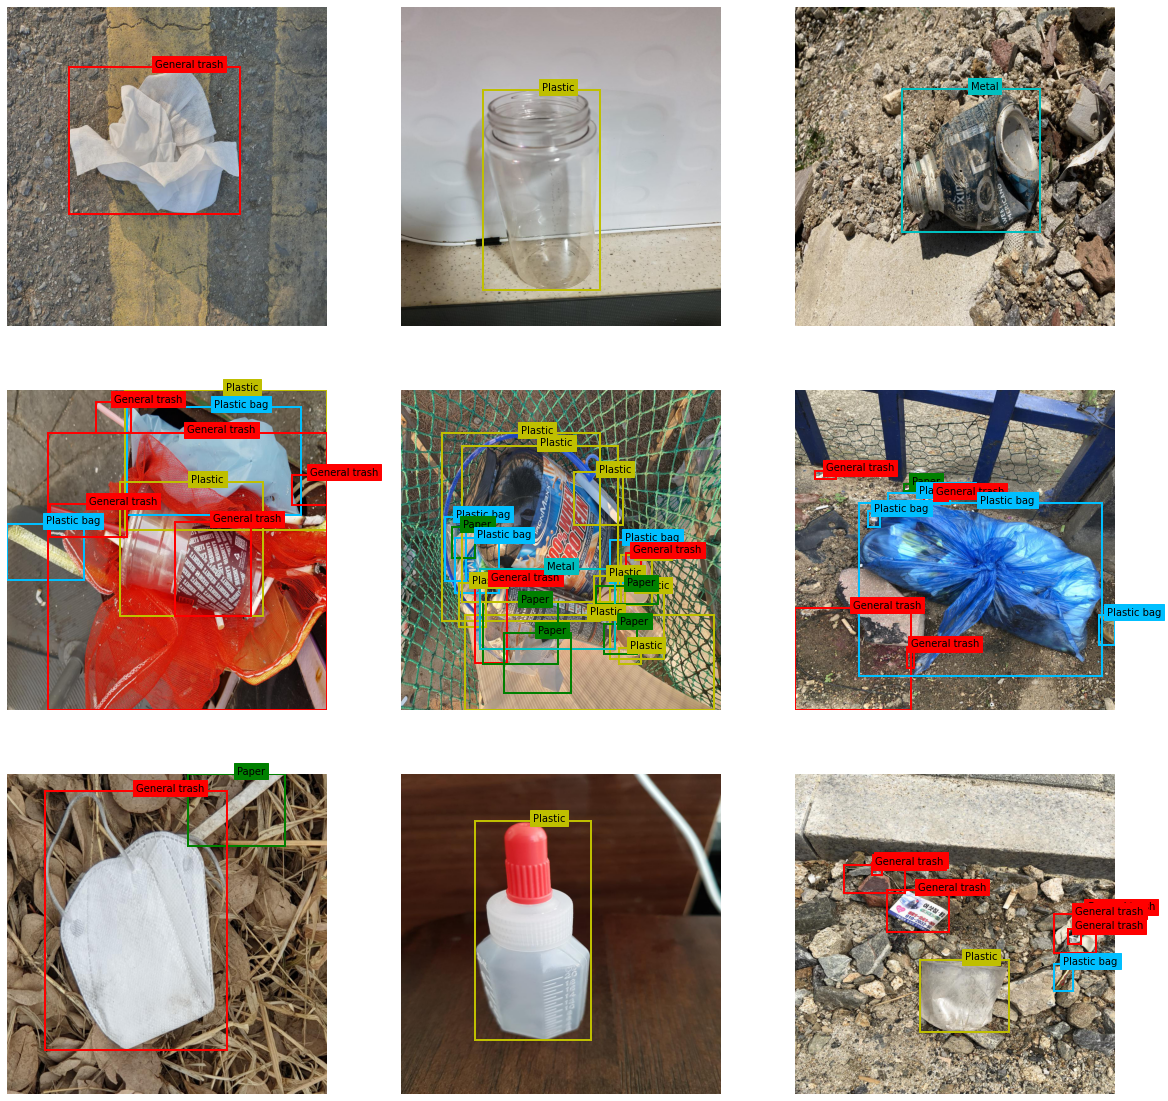

In [197]:
# Create figure and axes
fig, axes = plt.subplots(3, 3, figsize = (20, 20))
for i in range(3):
    for j in range(3):
        drawing_bbox(200 * i + 50 * j, axes[i][j])

plt.show()

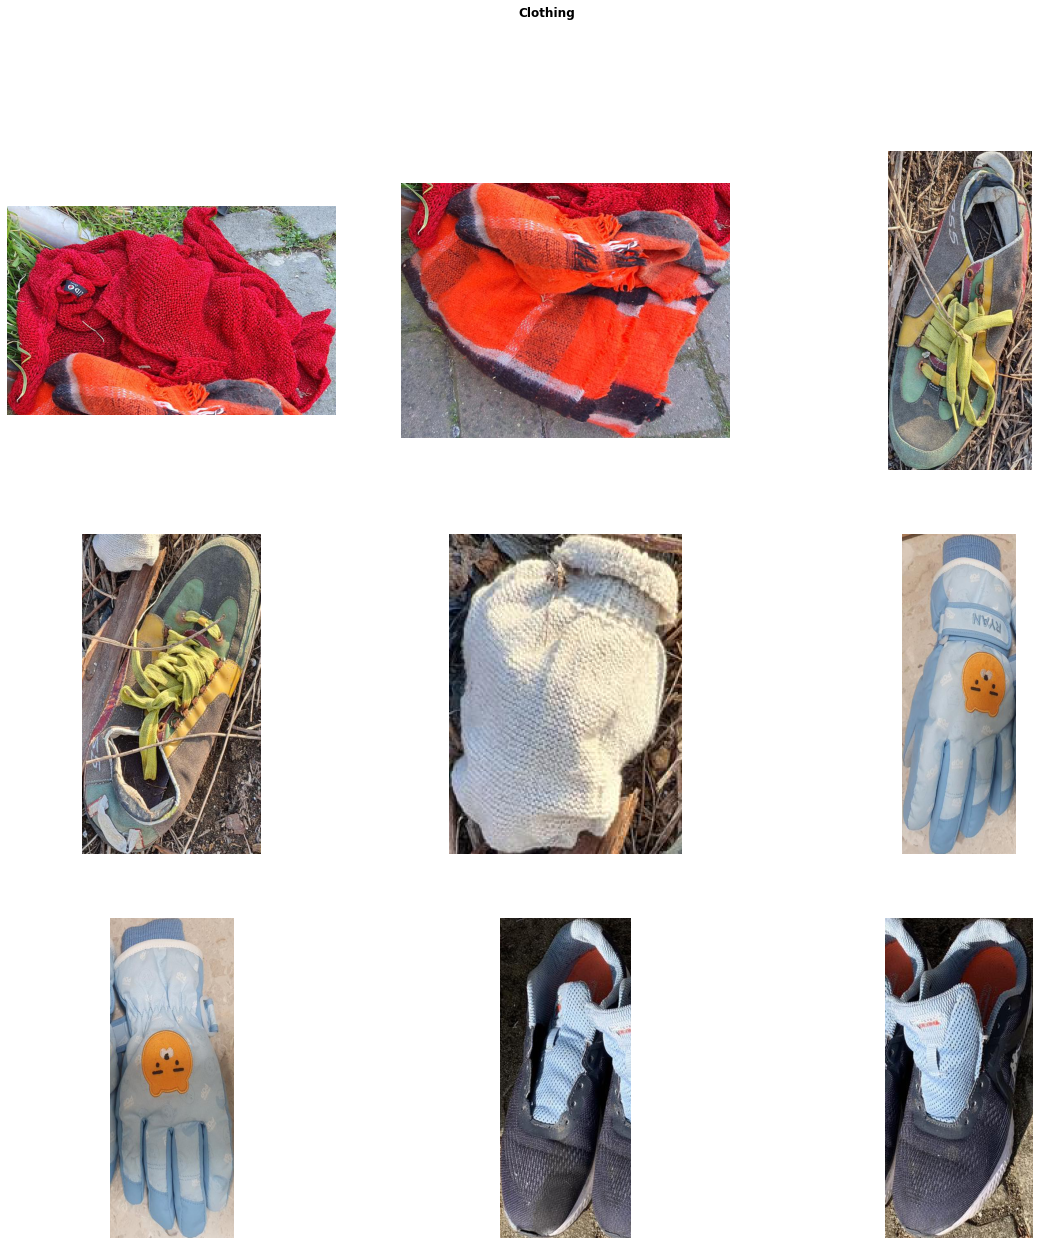

In [239]:
showing_trash(9)

## 쓰레기 종류

In [111]:
# category 별 개수 dicionary 
category_dict = {}
for i in range(len(annotations)):
    cate = categories[annotations[i]['category_id']]['name']
    if cate not in category_dict:
        category_dict[cate] = 1
    else:
        category_dict[cate] += 1
category_count = pd.DataFrame(list(category_dict.items()), columns=['Name', 'Quantity'])

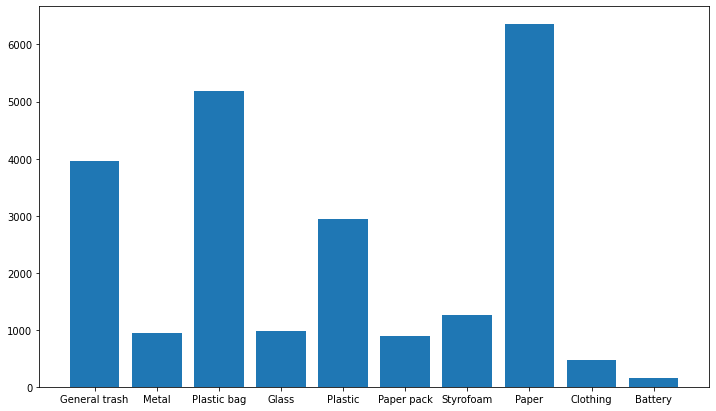

In [107]:
fig, ax = plt.subplots(1, 1, figsize = (12, 7))

ax.bar(
    category_count['Name'],
    category_count['Quantity']
)

plt.show()

쓰레기 카테고리간 불균형이 있음.

## Bounding Box 넓이 분포

In [159]:
# 각 bounding box의 area list
area_list = []
for i in range(len(annotations)):
    area_list.append(annotations[i]['area'])
area_list1 = [a for a in area_list if a < 10000]
print(len(area_list1)/len(area_list))
print(f"MIN:{min(area_list)}, MAX:{max(area_list)}")
area_df = pd.DataFrame(area_list, columns=['Area'])
print(area_df)

0.25012962322848253
MIN:0.56, MAX:1048371.21
            Area
0      257301.66
1       10402.56
2       26259.36
3       69096.17
4       24164.58
...          ...
23139  768591.81
23140   57309.72
23141    1772.74
23142   53008.67
23143  149633.22

[23144 rows x 1 columns]


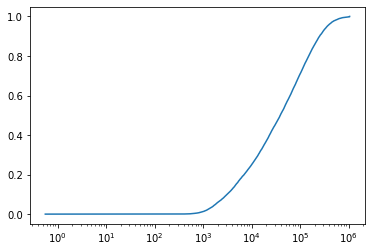

In [155]:
# compute the CDF
cdfx = sorted(area_list)
cdfy = np.linspace(1 / len(area_list), 1.0, len(area_list))
# plot the CDF
plt.plot(cdfx, cdfy)
plt.xscale('log')
plt.show()

[Text(0, 0, '(0.56, 6990.08)'),
 Text(1, 0, '(6991.08, 23418.57)'),
 Text(2, 0, '(23430.2, 62007.84)'),
 Text(3, 0, '(62041.5, 149517.72)'),
 Text(4, 0, '(149527.84, 1048371.21)')]

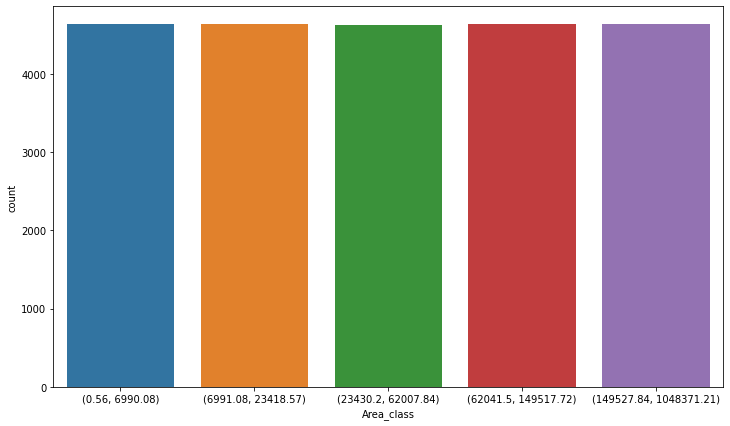

In [184]:
fig, ax = plt.subplots(1, 1, figsize = (12, 7))
area_df['Area_class'] = pd.qcut(area_df['Area'], 5, labels=['A','B','C','D','E'])
maxs = []
mins = []
for a in ['A', 'B','C','D','E']:
    mins.append(area_df['Area'][area_df['Area_class'] == a].min())
    maxs.append(area_df['Area'][area_df['Area_class'] == a].max())

sns.countplot(
    area_df['Area_class']
)
ax.set_xticklabels(list(zip(mins, maxs)))

bounding box가 아주 작은 것, 아주 큰 것도 별로 없다.